## Imports

In [32]:
import copy
import spacy
import pickle


import pandas as pd
import numpy as np

from datetime import datetime

from tqdm import tqdm_notebook as tqdm 

In [64]:
import en_core_web_trf
from spacy.lang.en import English

## Load models

In [65]:
nlp = en_core_web_trf.load()

sentencizer = English()
sentencizer.add_pipe("sentencizer")

## Data loading

### Load teh dataframe with articles meta data

In [4]:
tesla_articles_df = pd.read_csv('/home/jupyter/data/ner/theguardian/tesla_theguardian_df.csv', index_col=0)

In [5]:
tesla_articles_df.head()

,id,type,sectionId,webPublicationDate,webTitle,webUrl,apiUrl
0,business_2021_may_13_fund-management-irretriev...,article,business,2021-05-13T16:27:08Z,"Fund management ‘irretrievably broken’, says s...",https://www.theguardian.com/business/2021/may/...,https://content.guardianapis.com/business/2021...
1,business_2021_may_05_uk-car-sales-rebound-afte...,article,business,2021-05-05T09:21:07Z,UK car sales rebound after ‘one of darkest yea...,https://www.theguardian.com/business/2021/may/...,https://content.guardianapis.com/business/2021...
2,business_2021_apr_28_us-automakers-rules-auto-...,article,technology,2021-04-28T16:49:27Z,US automakers outline rules for auto-driving c...,https://www.theguardian.com/business/2021/apr/...,https://content.guardianapis.com/business/2021...
3,technology_2021_apr_26_tesla-record-quarterly-...,article,technology,2021-04-26T21:47:50Z,Tesla reports record quarterly profit as elect...,https://www.theguardian.com/technology/2021/ap...,https://content.guardianapis.com/technology/20...
4,commentisfree_2021_apr_25_elon-musk-jeff-bezos...,article,commentisfree,2021-04-25T05:00:07Z,"In space, no one will hear Bezos and Musk’s wo...",https://www.theguardian.com/commentisfree/2021...,https://content.guardianapis.com/commentisfree...


### Load one article

In [6]:
the_guardians_articles_directory = '/home/jupyter/data/ner/theguardian/articles/'
test_file = tesla_articles_df.iloc[0]["id"] + ".txt"
with open(the_guardians_articles_directory + test_file, 'r') as f:
    test_article = f.read()

##### Begining of the loaded article

In [63]:
test_article[:100] + " ..."

"Something very, very wrong is happening. I'm flying along the windy, cypress-lined roads of Pebble B ..."

### Apply sentencizer and NER models on the first article to see an example

In [69]:
doc = sentencizer(test_article)

spacy_ner_predictions = []
for sentence in doc.sents:
    spacy_ents_dict = {"string": str(sentence), "ents": []}
#     print(str(sentence))
    for ent in nlp(str(sentence)).ents:
        spacy_ents_dict["ents"].append({
            "start": ent.start_char,
            "end": ent.end_char,
            "ent_type":ent.label_,
            "ent_value":str(sentence)[ent.start_char:ent.end_char]
        })
    spacy_ner_predictions.append(spacy_ents_dict)

#### Display the NER results on the first 5 sentences

In [70]:
spacy_ner_predictions[:5]

[{'string': 'Something very, very wrong is happening.', 'ents': []},
 {'string': "I'm flying along the windy, cypress-lined roads of Pebble Beach in California being chased by a hairdryer.",
  'ents': [{'start': 51,
    'end': 63,
    'ent_type': 'GPE',
    'ent_value': 'Pebble Beach'},
   {'start': 67, 'end': 77, 'ent_type': 'GPE', 'ent_value': 'California'}]},
 {'string': 'Or at least that\'s what it sounds like. "', 'ents': []},
 {'string': 'Do you drive many high-performance cars?"', 'ents': []},
 {'string': 'asks Mike Harrigan, an executive from Tesla motors.',
  'ents': [{'start': 5,
    'end': 18,
    'ent_type': 'PERSON',
    'ent_value': 'Mike Harrigan'},
   {'start': 38, 'end': 43, 'ent_type': 'ORG', 'ent_value': 'Tesla'}]}]

## Extract the entities from all the article on Tesla from the guardian 

We will build a dataframe containing the following columns:
- article_id: The id of the article
- article_type: The type of article
- article_date: The date of publishing of teh article
- article_section: The section in which it belong
- article_title: The title of the article
- sentence_i: The sentence number in the article
- entity_type: The type of entity
- entity_value: The value of the entity found

In [109]:
org_pers_gpe_df_values = []
for line_i in tqdm(range(len(tesla_articles_df))):
    article_metadata = tesla_articles_df.iloc[line_i]
    article_id = article_metadata["id"]
    article_type = article_metadata["type"]
    article_date = article_metadata["webPublicationDate"]
    article_section = article_metadata["sectionId"]
    article_title = article_metadata["webTitle"]
    
    test_file = article_id + ".txt"
    with open(the_guardians_articles_directory + test_file, 'r') as f:
        test_article = f.read()

    doc = sentencizer(test_article)
    sentences = [s for s in doc.sents]
    nb_sentences_in_doc = len(sentences)
    for sentence_i, sentence in enumerate(sentences):

        for ent in nlp(str(sentence)).ents:
            if ent.label_ in ['PERSON', 'ORG', 'GPE']:
                org_pers_gpe_df_values.append({
                    "article_id": article_id,
                    "article_type": article_type,
                    "article_date": article_date,
                    "article_section": article_section,
                    "article_title": article_title,
                    "sentence_i": sentence_i,
                    "nb_sentences_in_doc": nb_sentences_in_doc,
                    "sentence": sentence,
                    "entity_type": ent.label_,
                    "entity_value": str(sentence)[ent.start_char:ent.end_char]
                })

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/404 [00:00<?, ?it/s]

##### Observation:
We 16,000 enetities in our 404 articles

In [110]:
len(org_pers_gpe_df_values)

16335

#### We build the dataframe out of the list of dictionnary

In [111]:
org_pers_gpe_df = pd.DataFrame(org_pers_gpe_df_values)
org_pers_gpe_df.head()

,article_id,article_type,article_date,article_section,article_title,sentence_i,nb_sentences_in_doc,sentence,entity_type,entity_value
0,business_2021_may_13_fund-management-irretriev...,article,2021-05-13T16:27:08Z,business,"Fund management ‘irretrievably broken’, says s...",0,31,"(The, star, technology, investor, James, Ander...",PERSON,James Anderson
1,business_2021_may_13_fund-management-irretriev...,article,2021-05-13T16:27:08Z,business,"Fund management ‘irretrievably broken’, says s...",1,31,"(The, outgoing, co, -, manager, of, the, FTSE,...",ORG,Scottish Mortgage Investment Trust
2,business_2021_may_13_fund-management-irretriev...,article,2021-05-13T16:27:08Z,business,"Fund management ‘irretrievably broken’, says s...",2,31,"(Anderson, ,, who, is, stepping, down, in, a, ...",PERSON,Anderson
3,business_2021_may_13_fund-management-irretriev...,article,2021-05-13T16:27:08Z,business,"Fund management ‘irretrievably broken’, says s...",2,31,"(Anderson, ,, who, is, stepping, down, in, a, ...",ORG,Baillie Gifford’s
4,business_2021_may_13_fund-management-irretriev...,article,2021-05-13T16:27:08Z,business,"Fund management ‘irretrievably broken’, says s...",2,31,"(Anderson, ,, who, is, stepping, down, in, a, ...",ORG,Tesla


## Entities analysis

#### We look at the number of entities found for each types

In [75]:
org_pers_gpe_df.entity_type.value_counts()

ORG       8419
PERSON    5049
GPE       2867
Name: entity_type, dtype: int64

### Methode:
For each type of enetities we will look at the top 20 most frequent. For a few examples of "unexpected" entities we will look at the article titles containing those enetities to understand their contexte. we will also look at their occurence through time to locate their impact in the time.


### Entity PERSON

In [91]:
org_pers_gpe_df[org_pers_gpe_df.entity_type == "PERSON"].entity_value.value_counts()[:20]

Musk            1457
Elon Musk        460
Elon Musk’s       74
Unsworth          66
Trump             64
Vandermeyden      51
Brown             43
Tripp             39
Bezos             37
Elon              31
Jeff Bezos        30
Tesla             28
Joshua Brown      27
Grimes            22
Therese           22
Broder            21
Ferro             20
Barbara           19
Edwards           19
Nick              19
Name: entity_value, dtype: int64

### We look at the articles mentioning Joshua Brown or Brown

In [88]:
def get_top_articles_related_to_entity(ent_val, ent_type, top=10):
    
    if type(ent_val) != list:
        ent_val = [ent_val]
    if type(ent_type) != list:
        ent_type = [ent_type]
        
    return org_pers_gpe_df[(org_pers_gpe_df.entity_value.isin(ent_val)) &\
                           (org_pers_gpe_df.entity_type.isin(ent_type))].article_title.value_counts()[:10]

get_top_articles_related_to_entity(ent_val=["Joshua Brown", "Brown"], ent_type="PERSON")

Tesla Model S cleared by auto safety regulator after fatal Autopilot crash           10
Tesla driver killed while using autopilot was watching Harry Potter, witness says     6
Tesla fatal autopilot crash: family may have grounds to sue, legal experts say        6
Elon Musk's self-driving evangelism masks risk of Tesla autopilot, experts say        6
What will happen when a self-driving car kills a bystander?                           5
Tesla drivers post viral, self-driving 'stunts' using autopilot technology            5
The first self-driving car fatality proves nothing | John Naughton                    5
Tesla driver dies in first fatal crash while using autopilot mode                     4
Elon Musk Twitter rant a 'case study' in how not to handle a crisis, experts say      3
Fatal crash prompts federal investigation of Tesla self-driving cars                  3
Name: article_title, dtype: int64

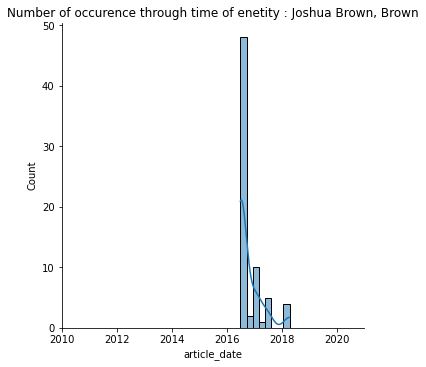

In [86]:
def get_importance_of_entity_through_time(ent_val, ent_type, start_period=datetime(2010, 1, 1), end_period=datetime(2021, 1, 1)):
    """
    
    """
    if type(ent_val) != list:
        ent_val = [ent_val]
    if type(ent_type) != list:
        ent_type = [ent_type]

    organisation_talk_dates = org_pers_gpe_df[(org_pers_gpe_df.entity_value.isin(ent_val)) &\
                                              (org_pers_gpe_df.entity_type.isin(ent_type))]\
            .article_date.apply(lambda x: datetime.strptime(x.split('T')[0], "%Y-%m-%d"))
    sns.displot(organisation_talk_dates, kde=True)
    plt.title(f'Number of occurence through time of enetity : {", ".join(ent_val)}')
    plt.xlim(left=datetime(2010, 1, 1), right=datetime(2021, 1, 1))
    plt.show()
    
get_importance_of_entity_through_time(ent_val=["Joshua Brown", "Brown"], ent_type="PERSON")

##### Observation:
We can deduce that Joshua Brown was a persone who died in a tesla car using the auto pilote. This accident had a fairly long term impact on the company's reputation as  Joshua Brown name's is mentionned more than 1 year after the accident.

### We look at the articles mentioning Barbara

In [92]:
get_top_articles_related_to_entity(ent_val="Barbara", ent_type="PERSON")

The lawyers taking on Silicon Valley sexism: 'It's far worse than people know'    19
Name: article_title, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


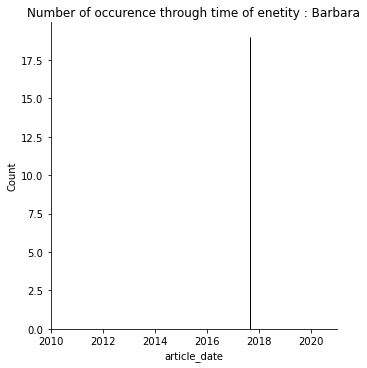

In [93]:
get_importance_of_entity_through_time(ent_val=["Barbara"], ent_type="PERSON")

In [102]:
barbara_articles = set(org_pers_gpe_df[(org_pers_gpe_df.entity_value.isin(["Barbara"])) &\
                (org_pers_gpe_df.entity_type == "PERSON")].article_id.values)

org_pers_gpe_df[(org_pers_gpe_df.article_id.isin(barbara_articles)) &\
                (org_pers_gpe_df.entity_type == "PERSON")].entity_value.value_counts()[:20]

Therese              22
Barbara              19
Pao                  10
Lawless               6
Ellen Pao             5
Therese Lawless       3
Ellen                 3
Susan Fowler          3
Chia Hong             2
Alan Axelrod          2
Elon Musk’s           2
Kalanick              2
Elizabeth Scott       2
James Damore          2
AJ Vandermeyden       2
Winni Wintermeyer     1
Marissa Mayer         1
Barbara Lawless       1
Eric Risberg          1
Ramin Talaie          1
Name: entity_value, dtype: int64

In [105]:
tesla_sexism_article_ids = set(org_pers_gpe_df[
    (org_pers_gpe_df.entity_value.isin(["Therese", "Lawless", "Barbara Lawless",
    "Ellen Pao", "Susan Fowler", "Chia Hong", "Elizabeth Scott"])) &\
    (org_pers_gpe_df.entity_type == "PERSON")].article_id.values)
tesla_sexism_article_ids

{'money_2017_sep_02_lawyers-silicon-valley-sexism-worse-google-uber-lawless-sisters',
 'technology_2017_feb_28_tesla-female-engineer-lawsuit-harassment-discrimination',
 'technology_2017_jun_01_tesla-fires-aj-vandermeyden-lawsuit-sexual-harrassment'}

##### Observations:

We can see that Barbara Lawless, as well as Therese Lawless, Ellen Pao, Susan Fowler, Chia Hong and Elizabeth Scott were all linked into a sexual harrasement and sexixm case within Tesla motors in 2017. We have seen that several people been in the same group of article can help to highlight a certain link between them.

### Entity GPE (Location)

In [24]:
org_pers_gpe_df[org_pers_gpe_df.entity_type == "GPE"].entity_value.value_counts()[:20]

US                 455
UK                 265
California         217
China               99
Australia           69
Fremont             67
London              57
South Australia     56
Germany             48
Britain             48
America             47
Nevada              45
Los Angeles         36
San Francisco       30
Florida             30
Japan               28
Paris               27
Thailand            26
Texas               26
New York            24
Name: entity_value, dtype: int64

### We look at the case of Fremont

In [112]:
get_top_articles_related_to_entity(ent_val="Fremont", ent_type="GPE")

'F*ck Elon Musk': Democrat rebukes magnate over coronavirus restrictions row                       6
Tesla workers’ unemployment may be suspended if they don't return, emails show                     5
Elon Musk v public health: a timeline of the Tesla factory standoff                                5
'How do they expect to run without us?' Tesla accused of axing key staff to cut costs              4
Tesla factory workers reveal pain, injury and stress: 'Everything feels like the future but us'    3
Former Tesla workers claim they were fired for using maternity and sick leave                      3
Billionaires add $1tn to net worth during pandemic as their workers struggle                       3
Tesla factory to be investigated over safety concerns                                              3
Tesla employee bus crashes into car, killing off-duty officer in California                        2
Elon Musk reopens California Tesla factory in defiance of lockdown order                   

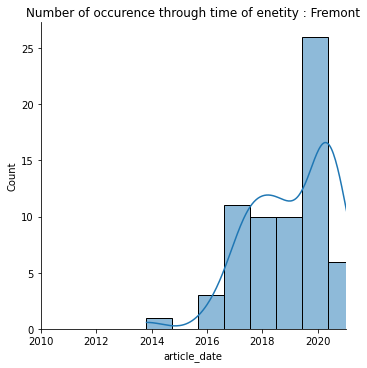

In [113]:
get_importance_of_entity_through_time(ent_val="Fremont", ent_type="GPE")

##### Observations:

We can deduce that a Tesla factory is established in Fremont, and that their was a lot of pressure in this factory in 2020 due to covid-19.

### Entity ORG (Organisation)

In [28]:
org_pers_gpe_df[org_pers_gpe_df.entity_type == "ORG"].entity_value.value_counts()[:20]

Tesla                3134
Google                160
Apple                 157
Guardian              146
SEC                   123
SpaceX                115
Amazon                113
Ford                   94
Facebook               87
Uber                   66
Nissan                 62
Toyota                 58
Reuters                54
Microsoft              51
Business Today         50
Guardian Business      50
Tesla Motors           49
Musk                   42
General Motors         41
GM                     41
Name: entity_value, dtype: int64

### We look at the case of the SEC

In [114]:
get_top_articles_related_to_entity(ent_val="SEC", ent_type="ORG")

Tesla CEO Elon Musk in 'clear violation' of SEC restraint, court hears           14
SEC sues Elon Musk for fraud and seeks to bar him from leading a company          9
Musk mocks 'Shortseller Enrichment Commission' after SEC settlement               8
Tesla shares drop as analysts divided on Musk’s future with the company           8
The strange saga of Elon Musk: inside his 'excruciating' year                     7
Elon Musk's lawyers say tweet did not violate court order                         6
Elon Musk's tweets investigated for possibly breaking law: reports                5
Tesla: production slows amid rocky start to the new year                          5
Tesla shareholders urged to oust Elon Musk over $55bn pay deal                    5
Tesla to be examined by SEC over Elon Musk's 'funding secured' tweet – report     4
Name: article_title, dtype: int64

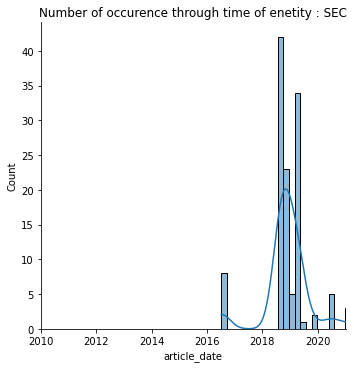

In [115]:
get_importance_of_entity_through_time(ent_val="SEC", ent_type="ORG")

##### Observations:

We can deduce that Tesla motors was sued by the SEC in 2019.